# `ellipticity.ipynb`

This notebook will test the formulae to determine the equation to get effective radius in an elliptical profile.

In [1]:
%matplotlib inline

import numpy as np
from scipy import integrate
from scipy import optimize
from tqdm.notebook import tqdm

from matplotlib import colors
import betterplotlib as bpl
bpl.set_style()

# Functions for the EFF profile

In [2]:
def eff_profile_2d(x, y, log_mu_0, x_c, y_c, a, q, eta):
    """
    2-dimensional EFF profile, in pixel units

    :param x: X pixel values
    :param y: Y pixel values
    :param log_mu_0: Log of the central surface brightness
    :param x_c: Center X pixel coordinate
    :param y_c: Center Y pixel coordinate
    :param a: Scale radius in the major axis direction
    :param q: Axis ratio. The small axis will have scale length qa
    :param theta: Position angle
    :param eta: Power law slope
    :return: Values of the function at the x,y coordinates passed in
    """

    x_term = ((x - x_c) / a) ** 2
    y_term = ((y - y_c) / (q * a)) ** 2
    return (10 ** log_mu_0) * (1 + x_term + y_term) ** (-eta)

In [3]:
def create_model_image(image_size, log_mu_0, x_c, y_c, a, q, eta):
    """ Create a model image using the EFF parameters. """
    # first generate the x and y pixel coordinates of the model image
    x_values = np.zeros((image_size, image_size))
    y_values = np.zeros((image_size, image_size))

    for x in range(image_size):
        x_values[:, x] = x
    for y in range(image_size):
        y_values[y, :] = y

    model_image = eff_profile_2d(
        x_values, y_values, log_mu_0, x_c, y_c, a, q, eta
    )

    return model_image

In [30]:
def plot_model_image(image_size, log_mu_0, x_c, y_c, a, q, eta):
    fig, ax = bpl.subplots()
    
    model_image = create_model_image(image_size, log_mu_0, x_c, y_c, a, q, eta)
    
    vmax = np.max(model_image)
    norm = colors.SymLogNorm(vmin=0, vmax=vmax, linthresh=0.0001 * vmax)
    cmap = bpl.cm.lapaz
    
    im = ax.imshow(model_image, norm=norm, cmap=cmap, origin="lower")
    fig.colorbar(im, ax=ax)
    
    ax.remove_labels("both")
    ax.remove_spines(["all"])
    
    return fig, ax

# Make functions to determine the limits of integration for an elliptical profile

This function can be used in the special case of spherical profiles too. These equations take a few parameters, but these can be passed in via lambda when doing the actual integration. 

In [5]:
def y_limits_inner(x, x_0, x_c, y_c, a, q, upper):
    # x_0 is the width of this ellipse, measured from the center.
    # When q=1, this is the radius of the circle. Otherwise it is the
    # semi-major axis of the ellipse.
    term_x = ((x - x_c) / a)**2
    term_x_0 = (x_0 / a)**2
    
    term_pm = q * a * np.sqrt(term_x_0 - term_x)
    # this will either be plus or minus that term
    if not upper:
        term_pm *= -1
    return y_c + term_pm

def y_limits(xs, x_0, x_c, y_c, a, q, upper):
    return [y_limits_inner(x, x_0, x_c, y_c, a, q, upper) for x in xs]

Test that this worked as expected.

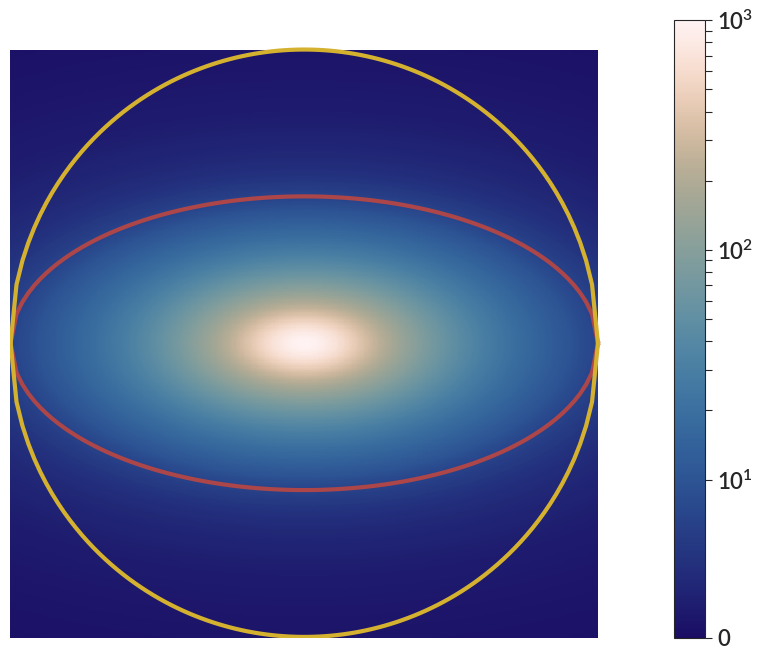

In [6]:
x_0 = 250

x_c = 250
y_c = 250
a = 50
q = 0.5

fig, ax = plot_model_image(
    image_size=500, 
    log_mu_0=3, 
    x_c=x_c, 
    y_c=y_c, 
    a=a, 
    q=q, 
    eta=1.5, 
)

xs = np.linspace(x_c - x_0, x_c + x_0, 100)
ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, q, True), c=bpl.color_cycle[3], alpha=1.0)
ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, q, False), c=bpl.color_cycle[3], alpha=1.0)

ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, 1.0, True), c=bpl.color_cycle[4], alpha=1.0)
ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, 1.0, False), c=bpl.color_cycle[4], alpha=1.0)

Messing with these parameters showed that it does work correctly.

# determining true r_eff

Here I will determine the actual half light radius, then compare it to the one calculated assuming spherical symmetry.

In [25]:
def integrate_ellipse(x_0, log_mu_0, a, q_profile, q_boundary, eta):
    integrand = lambda y, x: eff_profile_2d(x, y, log_mu_0, 0, 0, a, q_profile, eta)
    upper_func = lambda x: y_limits_inner(x, x_0, 0, 0, a, q_boundary, True)
    lower_func = lambda x: y_limits_inner(x, x_0, 0, 0, a, q_boundary, False)
    
    return integrate.dblquad(integrand, 
                             a=-x_0, 
                             b=x_0,
                             gfun=lower_func,
                             hfun=upper_func)[0]

In [8]:
def spherical_half_mass_radius(log_mu_0, a, q, eta, rmax):
    total_mass = integrate_ellipse(rmax, log_mu_0, a, q, 1.0, eta)
    
    def half_mass_diff(radius):
        this_mass = integrate_ellipse(radius, log_mu_0, a, q, 1.0, eta)
        return abs(this_mass - 0.5 * total_mass)
    
    return optimize.minimize_scalar(half_mass_diff, bounds=(0, rmax)).x

# First test that the analytic equation returns the correct values for circular profiles

In [9]:
def eff_profile_r_eff_with_rmax(eta, a, rmax):
    """
    Calculate the effective radius of an EFF profile, assuming a maximum radius.

    :param eta: Power law slope of the EFF profile
    :param a: Scale radius of the EFF profile, in any units.
    :param rmax: Maximum radius for the profile, in the same units as a.
    :return: Effective radius, in the same units as a and rmax
    """
    # This is such an ugly formula, put it in a few steps
    term_1 = 1 + (1 + (rmax / a) ** 2) ** (1 - eta)
    term_2 = (0.5 * (term_1)) ** (1 / (1 - eta)) - 1
    return a * np.sqrt(term_2)

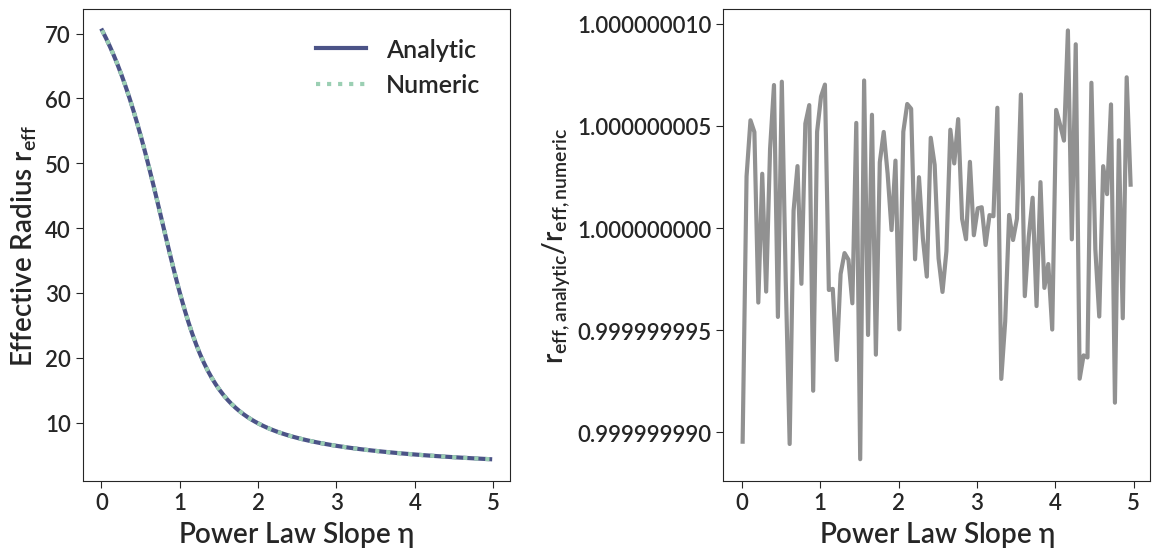

In [10]:
fig, axs = bpl.subplots(figsize=[12, 6], ncols=2)

a = 10
rmax = 10*a
etas = np.arange(0.01, 5, 0.05)
r_eff_analytic = []
r_eff_numeric = []
for eta in tqdm(etas):
    r_eff_analytic.append(eff_profile_r_eff_with_rmax(eta, a, rmax))
    r_eff_numeric.append(spherical_half_mass_radius(3, a, 1.0, eta, rmax))
    

axs[0].plot(etas, r_eff_analytic, label='Analytic')
axs[0].plot(etas, r_eff_numeric, ls=":", label="Numeric")
axs[0].legend()
axs[0].add_labels("Power Law Slope $\eta$", "Effective Radius $r_{eff}$")

axs[1].plot(etas, np.array(r_eff_analytic) / np.array(r_eff_numeric), c=bpl.color_cycle[2])
axs[1].add_labels("Power Law Slope $\eta$", "$r_{eff, analytic} / r_{eff, numeric}$")
fig.savefig("spherical_r_eff_validation.png")

# Then compare the true effective radius to the naive analytic one for elliptical profiles

Precalculate the numerical values for lots of values of eta to make these plots much easier.

In [58]:
a = 1
rmax = 100*a

float_etas = [0.1, 0.5, 0.9, 1.1, 1.3, 1.5, 2.5, 3.5, 4.5]
etas = [str(n) for n in float_etas]
numeric_qs = [0.02, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

r_eff_numerical_r100 = {eta: [spherical_half_mass_radius(3, a, q, float(eta), 100*a) 
                              for q in numeric_qs]
                        for eta in tqdm(etas)}
r_eff_numerical_r10 = {eta: [spherical_half_mass_radius(3, a, q, float(eta), 10*a) 
                             for q in numeric_qs]
                       for eta in tqdm(etas)}
r_eff_numerical_r3 = {eta: [spherical_half_mass_radius(3, a, q, float(eta), 3*a) 
                             for q in numeric_qs]
                       for eta in tqdm(etas)}

/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/scipy/integrate/quadpack.py:864: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/scipy/integrate/quadpack.py:864: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [61]:
r_eff_numerical_r100_norm = {eta: [r_eff / r_eff_numerical_r100[eta][-1] 
                                   for r_eff in r_eff_numerical_r100[eta]]
                             for eta in r_eff_numerical_r100}
r_eff_numerical_r10_norm = {eta: [r_eff / r_eff_numerical_r10[eta][-1] 
                                  for r_eff in r_eff_numerical_r10[eta]]
                            for eta in r_eff_numerical_r10}
r_eff_numerical_r3_norm = {eta: [r_eff / r_eff_numerical_r3[eta][-1] 
                                 for r_eff in r_eff_numerical_r3[eta]]
                           for eta in r_eff_numerical_r3}

In [65]:
def naive_correction(q):
    return (1 + q) * 0.5

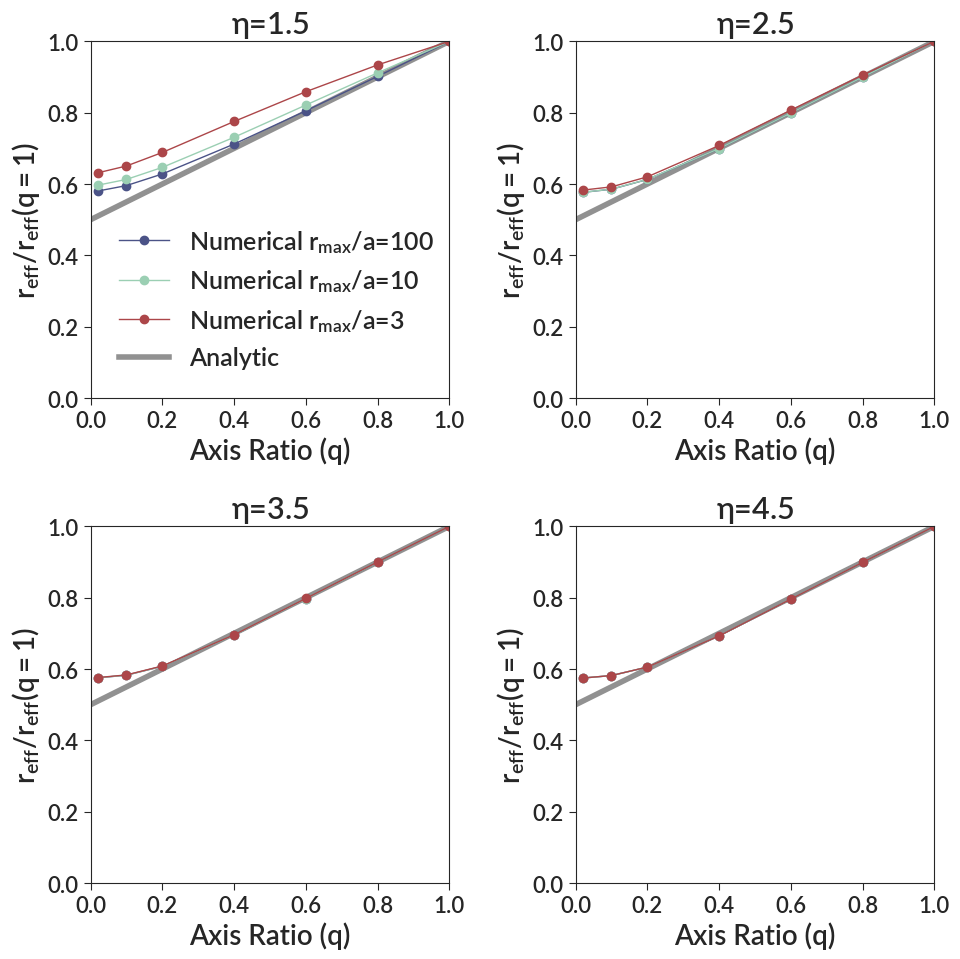

In [101]:
fig, axs = bpl.subplots(nrows=2, ncols=2, figsize=[10, 10])
axs = axs.flatten()

analytic_qs = np.linspace(0, 1.0, 100)

for eta, ax in zip(etas[-4:], axs):
    r_eff_numeric_100 = r_eff_numerical_r100_norm[eta]
    r_eff_numeric_10 = r_eff_numerical_r10_norm[eta]
    r_eff_numeric_3 = r_eff_numerical_r3_norm[eta]
    r_eff_analytic = [naive_correction(q) 
                      for q in analytic_qs]
    
    
    ax.plot(numeric_qs, r_eff_numeric_100, lw=1, c=bpl.color_cycle[0], marker="o", label='Numerical $r_{max}/a$=100', zorder=2)
    ax.plot(numeric_qs, r_eff_numeric_10, lw=1, c=bpl.color_cycle[1], marker="o", label='Numerical $r_{max}/a$=10', zorder=2)
    ax.plot(numeric_qs, r_eff_numeric_3, lw=1, c=bpl.color_cycle[3], marker="o", label='Numerical $r_{max}/a$=3', zorder=2)
    ax.plot(analytic_qs, r_eff_analytic, lw=4, c=bpl.color_cycle[2], label="Analytic", zorder=1)
    
    ax.add_labels("Axis Ratio (q)", "$r_{eff} / r_{eff}(q=1)$", f'$\eta$={eta}')
    ax.set_limits(0, 1, 0, 1)

axs[0].legend()
fig.savefig("elliptical_r_eff.png")

# Understanding what's going on with eta ~ 1

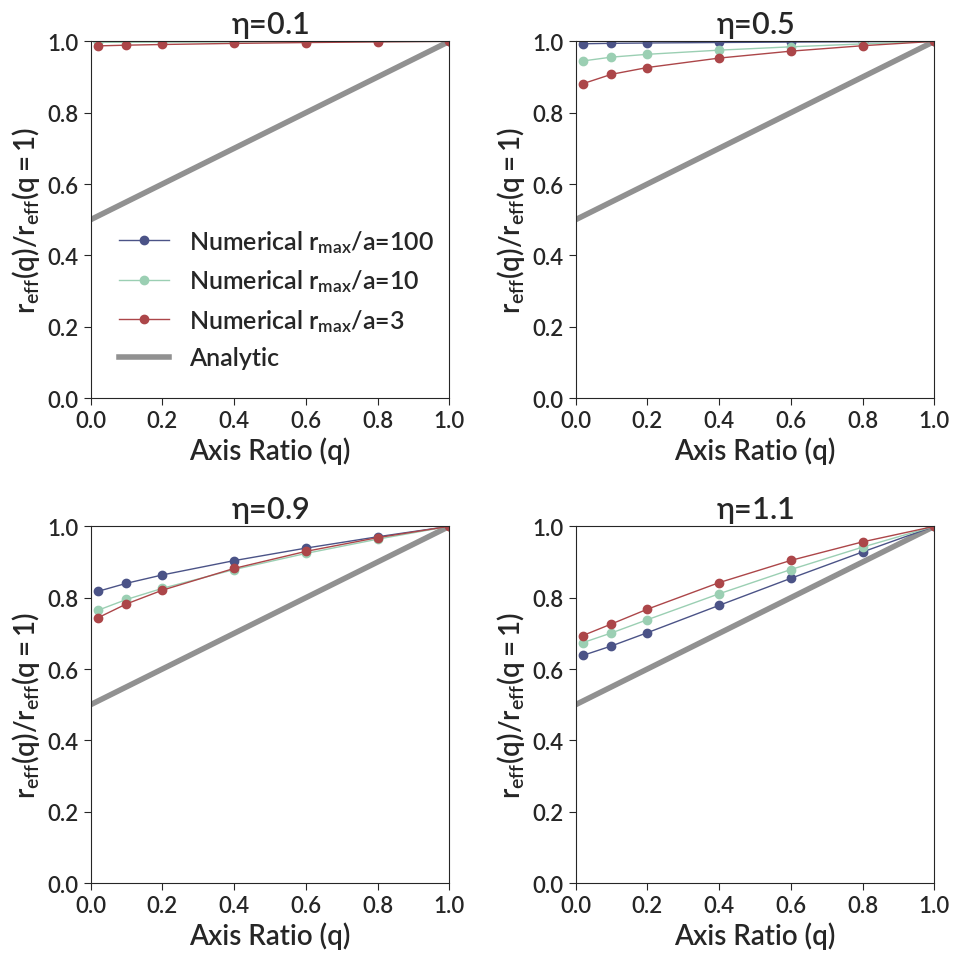

In [108]:
fig, axs = bpl.subplots(nrows=2, ncols=2, figsize=[10, 10])
axs = axs.flatten()

analytic_qs = np.linspace(0, 1.0, 100)

for eta, ax in zip(etas[:4], axs):
    r_eff_numeric_100 = r_eff_numerical_r100_norm[eta]
    r_eff_numeric_10 = r_eff_numerical_r10_norm[eta]
    r_eff_numeric_3 = r_eff_numerical_r3_norm[eta]
    r_eff_analytic = [naive_correction(q) 
                      for q in analytic_qs]
    
    
    ax.plot(numeric_qs, r_eff_numeric_100, lw=1, c=bpl.color_cycle[0], marker="o", label='Numerical $r_{max}/a$=100', zorder=2)
    ax.plot(numeric_qs, r_eff_numeric_10, lw=1, c=bpl.color_cycle[1], marker="o", label='Numerical $r_{max}/a$=10', zorder=2)
    ax.plot(numeric_qs, r_eff_numeric_3, lw=1, c=bpl.color_cycle[3], marker="o", label='Numerical $r_{max}/a$=3', zorder=2)
    ax.plot(analytic_qs, r_eff_analytic, lw=4, c=bpl.color_cycle[2], label="Analytic", zorder=1)
    
    ax.add_labels("Axis Ratio (q)", "$r_{eff}(q) / r_{eff}(q=1)$", f'$\eta$={eta}')
    ax.set_limits(0, 1, 0, 1)

axs[0].legend()
fig.savefig("elliptical_r_eff_low_eta.png")

This is happening because r_max comes into play. Try to make a separate correction

Instead of assuming the slope, let's just measure it as a function of eta, then we can apply that generically.

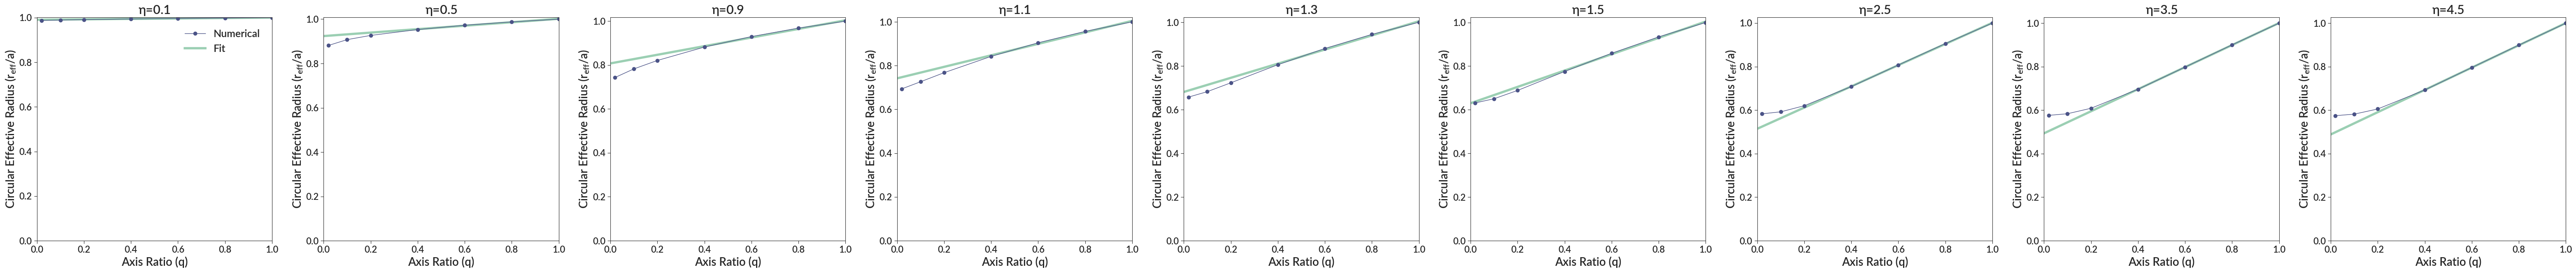

In [99]:
fig, axs = bpl.subplots(ncols=len(etas), figsize=[7*len(etas), 7])
axs = axs.flatten()

eta_reff_slopes = []
eta_reff_intercepts = []

for eta, ax in tqdm(zip(etas, axs)):
    r_eff_numeric_norm = r_eff_numerical_r3_norm[eta]
    
    slope, intercept = np.polyfit(x=numeric_qs[-4:], y=r_eff_numeric_norm[-4:], deg=1)
    eta_reff_intercepts.append(intercept)
    eta_reff_slopes.append(slope)
                     
    fit_r_eff = [intercept + slope * q for q in analytic_qs]
    
    ax.plot(numeric_qs, r_eff_numeric_norm, lw=1, marker="o", label='Numerical', zorder=2)
    ax.plot(analytic_qs, fit_r_eff, lw=4, label="Fit", zorder=1)
    
    ax.add_labels("Axis Ratio (q)", "Circular Effective Radius ($r_{eff} / a$)", f'$\eta$={eta}')
    ax.set_limits(0, 1, 0)

axs[0].legend()

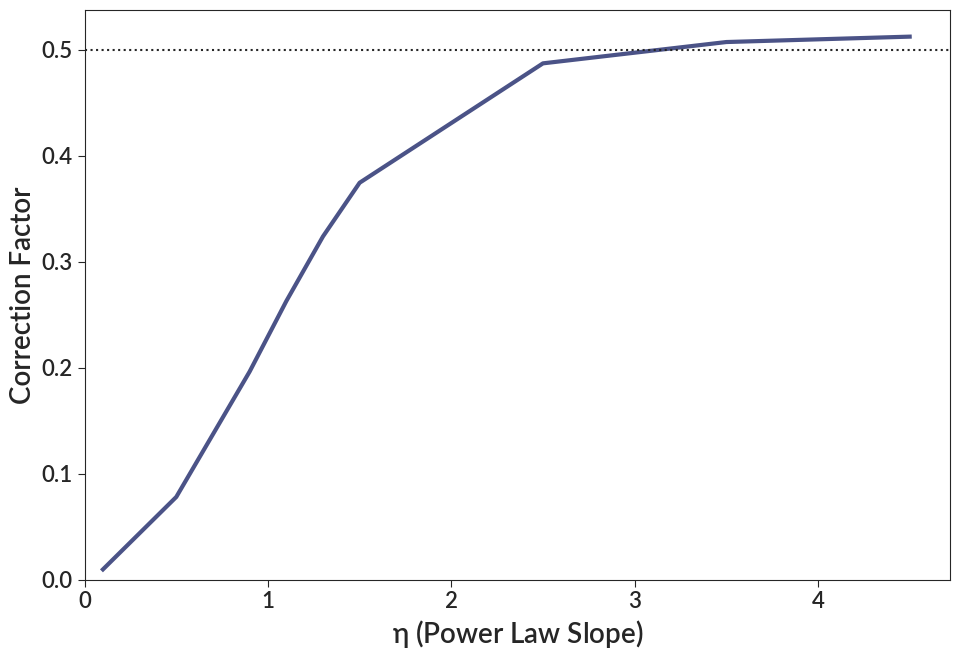

In [100]:
fig, ax = bpl.subplots()
ax.plot(float_etas, eta_reff_slopes)
ax.add_labels("$\eta$ (Power Law Slope)", "Correction Factor")
ax.axhline(0.5, ls=':')
ax.set_limits(0, y_min=0)

In [81]:
# x_c = 250
# y_c = 250
# a = 1
# q = 1

# eta = 0.5

# rmax=100*a
# x_0 = rmax

# fig, ax = plot_model_image(
#     image_size=500, 
#     log_mu_0=3, 
#     x_c=x_c, 
#     y_c=y_c, 
#     a=a, 
#     q=q, 
#     eta=eta, 
# )

# xs = np.linspace(x_c - x_0, x_c + x_0, 100)
# ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, q, True), c=bpl.color_cycle[3], alpha=1.0)
# ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, q, False), c=bpl.color_cycle[3], alpha=1.0)

# ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, 1.0, True), c=bpl.color_cycle[4], alpha=1.0)
# ax.plot(xs, y_limits(xs, x_0, x_c, y_c, a, 1.0, False), c=bpl.color_cycle[4], alpha=1.0)

# print(integrate_ellipse(rmax, 3, a, q, 1.0, eta))
# print(integrate_ellipse(15*a, 3, a, q, 1.0, eta))